# Playground - RSA (Respiratory sinus arrhythmia)
Very helpful - official repo of the physio library (processing ECG and Respiratory signals) - https://github.com/samuelgarcia/physio_benchmark/tree/main

Dataset is Zenodo

In [1]:
import os
import numpy as np
import tqdm
import neurokit2 as nk
import matplotlib.pyplot as plt
from customLib.vis import plot_ecg
from customLib.preprocess import myConv1D
from customLib.preprocess import dwt_denoise
from customLib.preprocess import resample_signal
from customLib.preprocess import split_signal
from customLib.create_dataset import label_ecgs
from customLib.peak_detection import group_peaks, find_mean_avg_r_peak_indices


In [2]:
path = "E:\\ml-data\\masters-thesis\\RSA\\Zenodo\\human"

In [3]:
sample_data = np.loadtxt(path +"\\S00.txt")
sample_data.shape
raw_ecg = sample_data[:, 0]
raw_resp = sample_data[:, 1]

srate = 1000
times = np.arange(raw_ecg.size) / srate

[]

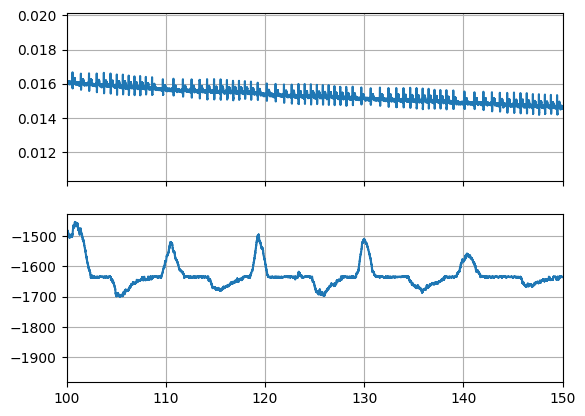

In [4]:
fig, axs = plt.subplots(sharex=True, nrows=2)
ax = axs[0]
ax.plot(times, raw_ecg)
ax.grid()

ax = axs[1]
ax.plot(times, raw_resp)
ax.grid()

ax.set_xlim(100, 150)
plt.plot()


[]

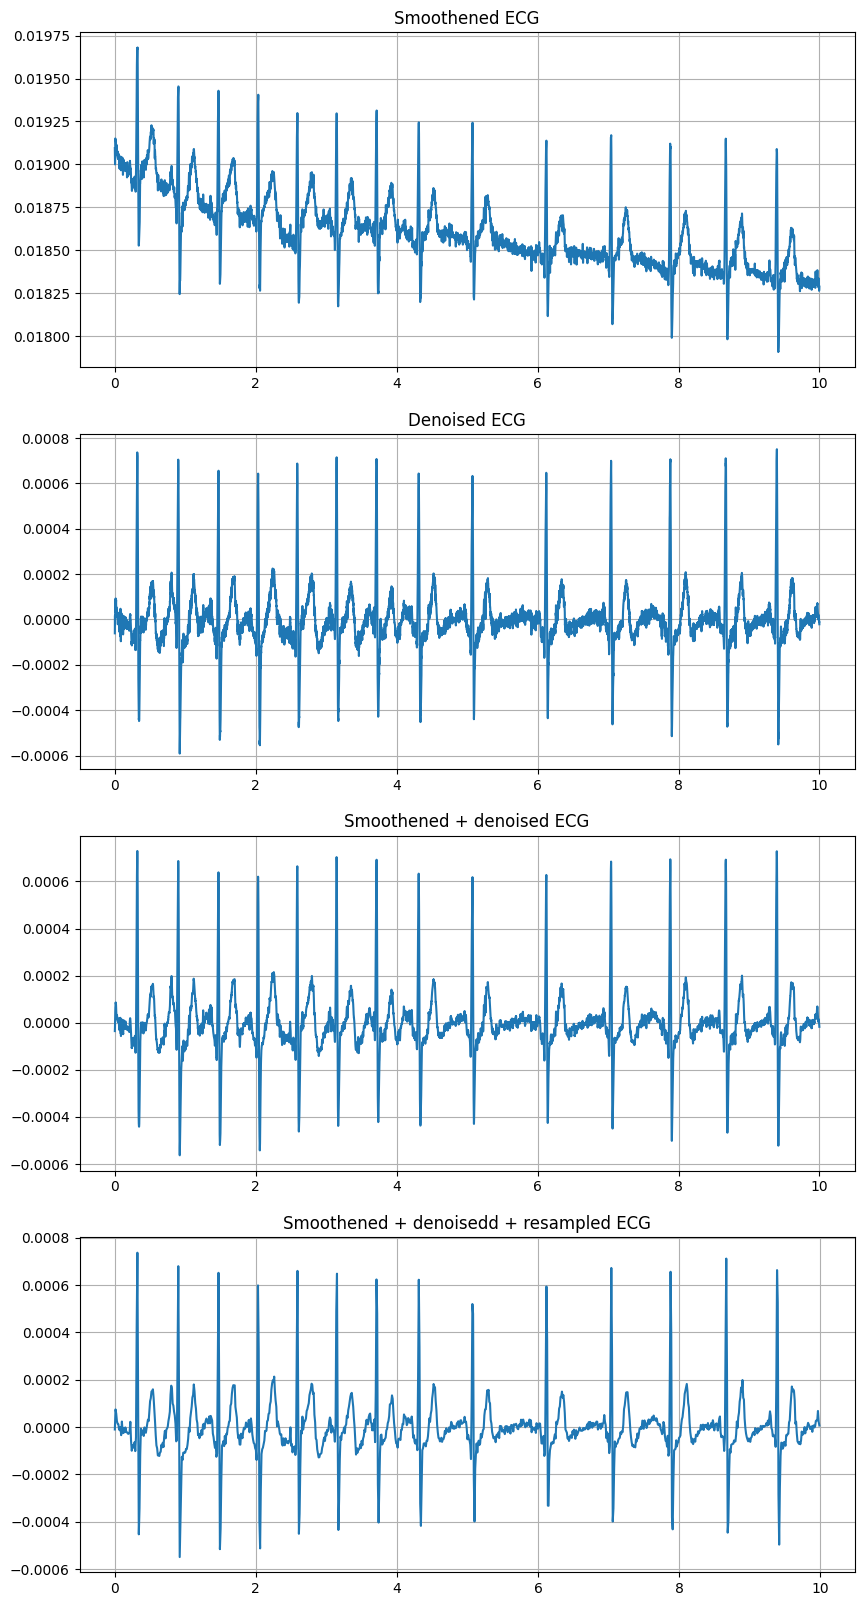

In [5]:
ecg_sample = raw_ecg[:10000]
smoothened_ecg = myConv1D(signal=ecg_sample, kernel_length=5, padding="same")
denoised_ecg = dwt_denoise(signal=ecg_sample)
smoothened_denoised = myConv1D(signal=denoised_ecg, kernel_length=5, padding="same")
smoothened_denoised_downsampled = resample_signal(smoothened_denoised, 1000)
time_resampled = times[:10000:10]

fig, axs = plt.subplots(nrows=4)
ax = axs[0]
ax.set_title("Smoothened ECG")
ax.plot(times[:10000], smoothened_ecg)
ax.grid()

ax = axs[1]
ax.set_title("Denoised ECG")
ax.plot(times[:10000], denoised_ecg)
ax.grid()

ax = axs[2]
ax.set_title("Smoothened + denoised ECG")
ax.plot(times[:10000], smoothened_denoised)
ax.grid()


ax = axs[3]
ax.set_title("Smoothened + denoisedd + resampled ECG")
ax.plot(time_resampled, smoothened_denoised_downsampled)
ax.grid()

fig.set_size_inches(10, 20)
plt.plot()

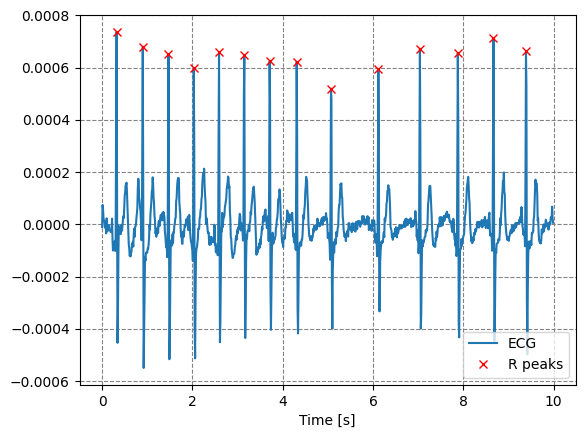

In [6]:
_, r_peaks = nk.ecg_peaks(ecg_cleaned=smoothened_denoised_downsampled, sampling_rate=100)
r_peaks = r_peaks["ECG_R_Peaks"]
plot_ecg(smoothened_denoised_downsampled, r_peaks, 100)

### Test pretrained LSTM for R-peak detection

In [7]:
import torch
from models.models import LSTM

In [8]:
model = LSTM(input_dim=1, hidden_size=32, lr=1e-4, loss_pos_weight=torch.Tensor(1))
model.load_state_dict(torch.load(".\\checkpoints\\lstm\\lstm_epoch_100_acc_99.76_f1_0.97.pt"))

Training will be performed with: cuda:0


e:\anaconda3\envs\torch\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


<All keys matched successfully>

In [9]:
smoothened_ecg = myConv1D(raw_ecg, 5, "same")
resampled_ecg = smoothened_ecg[::10]
ecgs = split_signal(signal=resampled_ecg, window_in_seconds=10, fs=100, normalize=False)
ecgs = [dwt_denoise(ecg) for ecg in ecgs]
ecgs = np.array(ecgs)

x, y = label_ecgs(ecgs=ecgs, sampling_rate=100)

Total ECGs: 33


100%|██████████| 33/33 [00:00<00:00, 969.69it/s]


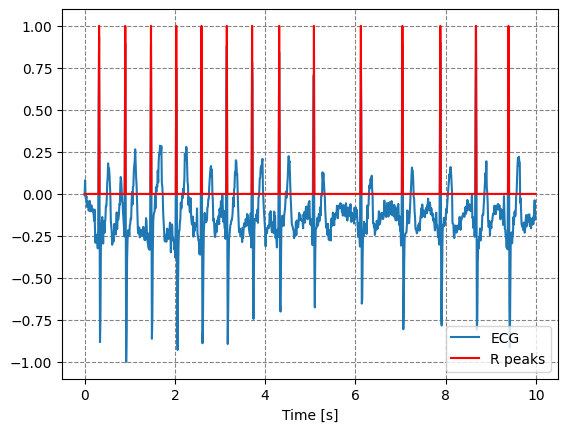

In [10]:
plot_ecg(x[0], y[0], 100)

In [11]:
x = np.expand_dims(x, axis=2)
y = np.expand_dims(y, axis=2)

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

x_tensor = torch.from_numpy(x)
x_tensor = x_tensor.to(device)
x_tensor = x_tensor.float()

sigmoid = torch.nn.Sigmoid()

predictions = model.forward(x_tensor)
predictions = predictions.cpu().detach()
predictions = sigmoid(predictions)
predictions = predictions.numpy()

In [13]:
def peaks_to_rri(r_peaks: np.ndarray, sampling_rate=100):
  if np.max(r_peaks) > 1: # passed as indices vector
    indices = r_peaks
  else:
    indices = np.where(r_peaks == 1)[0]

  indices_seconds = indices * 1 / sampling_rate * 1000

  rri = np.diff(indices_seconds)
  return rri

C:\Users\patry\AppData\Local\Temp\ipykernel_20072\682270942.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(ncols=2)


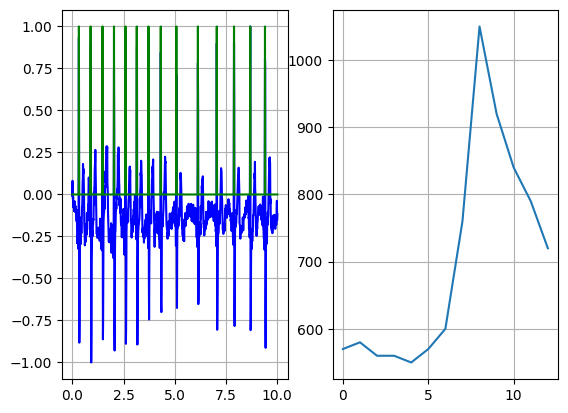

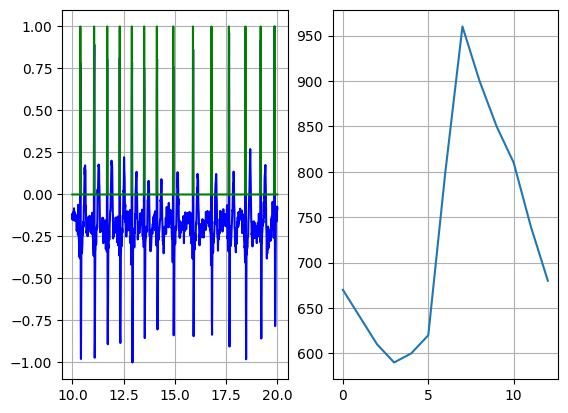

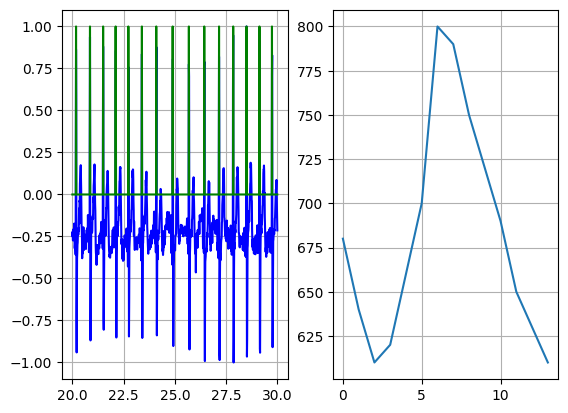

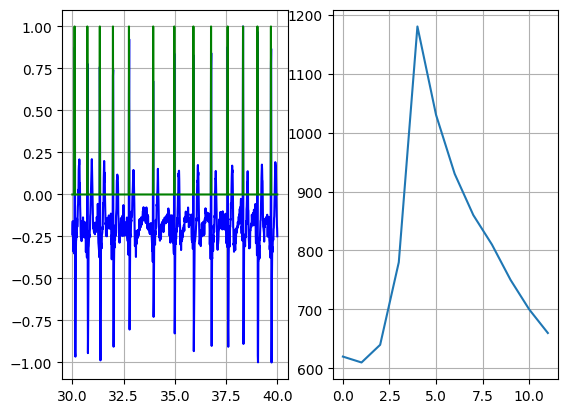

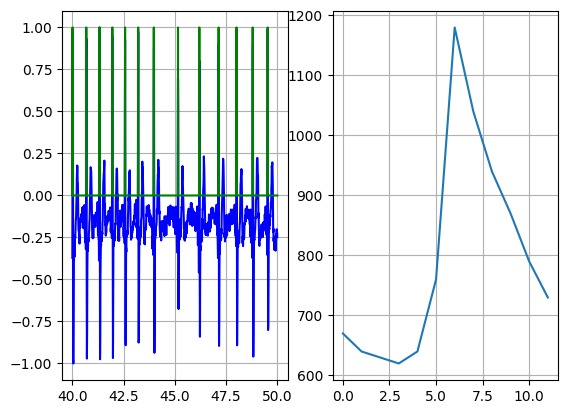

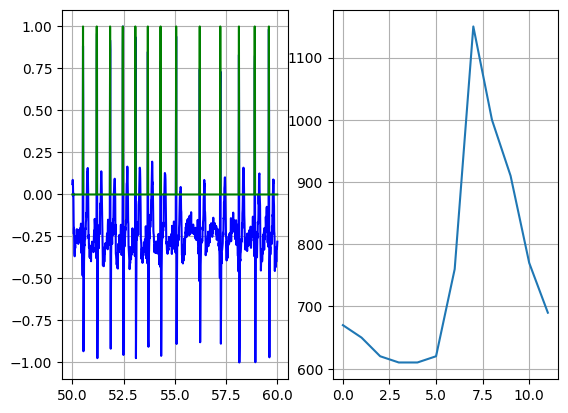

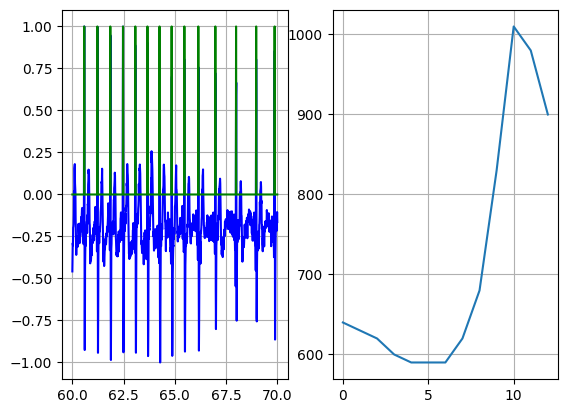

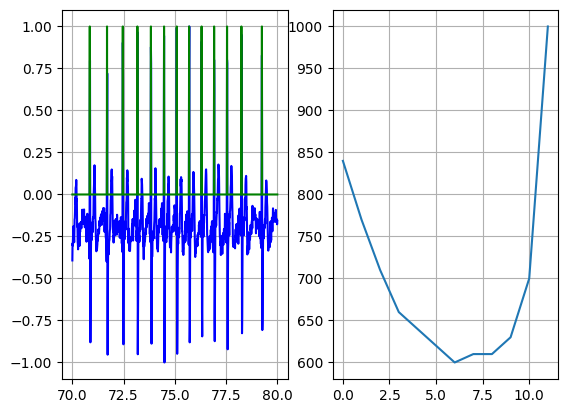

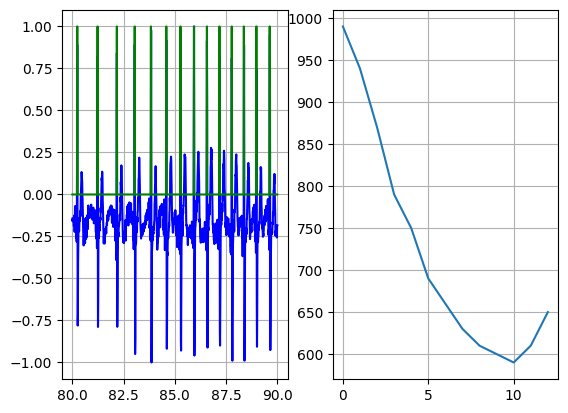

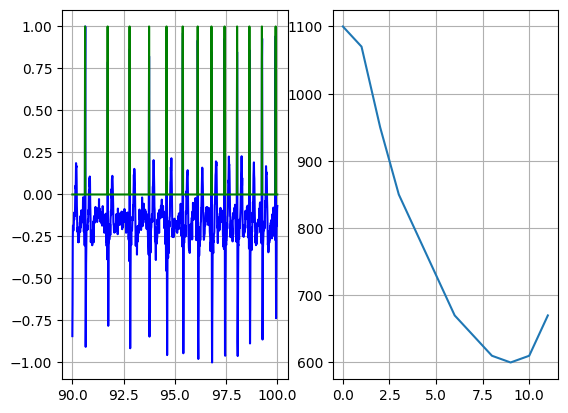

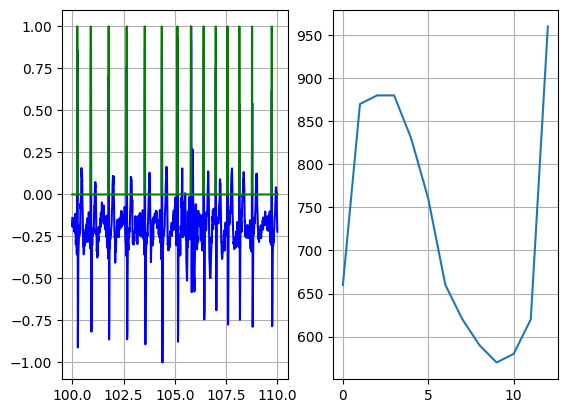

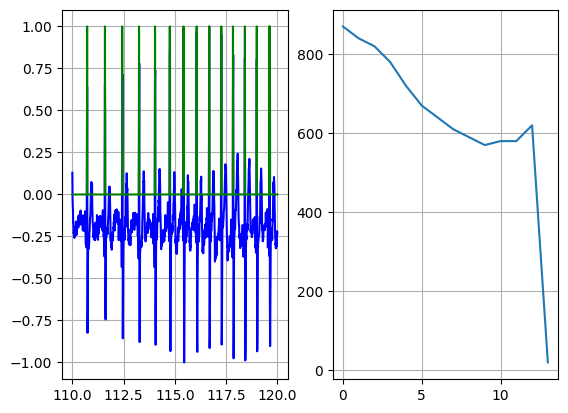

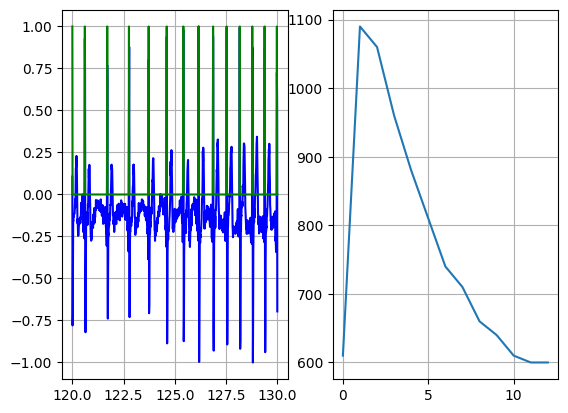

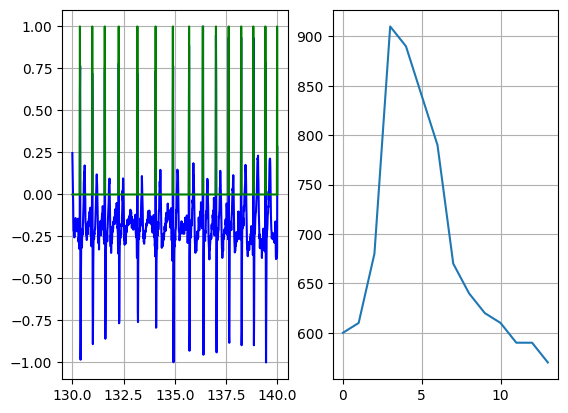

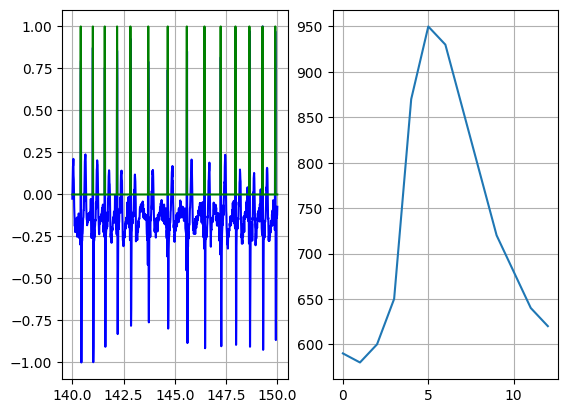

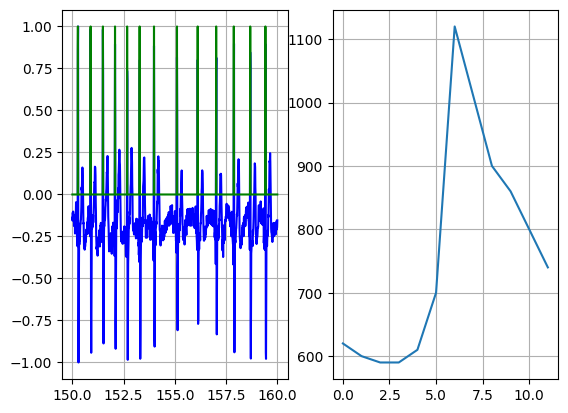

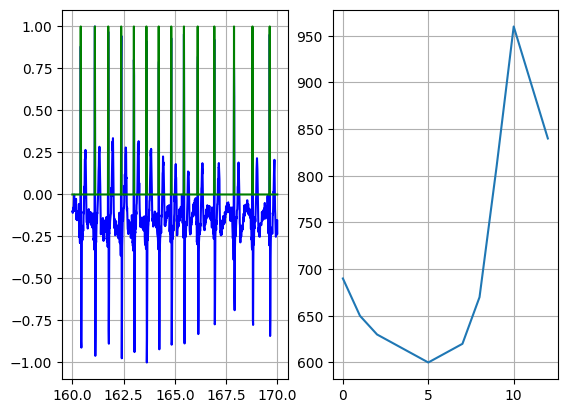

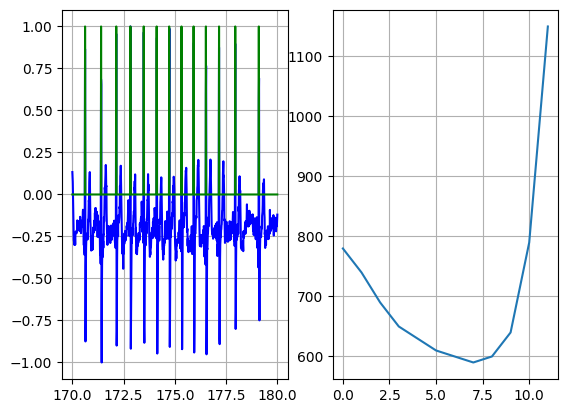

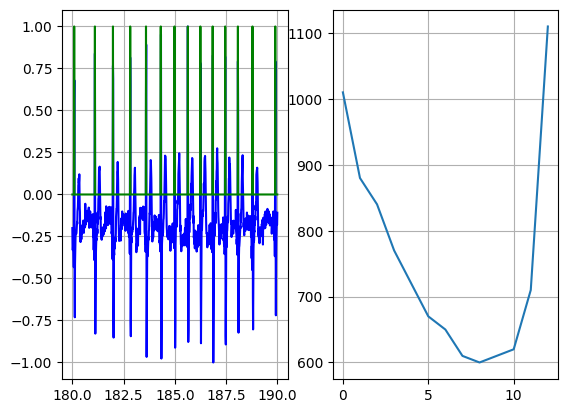

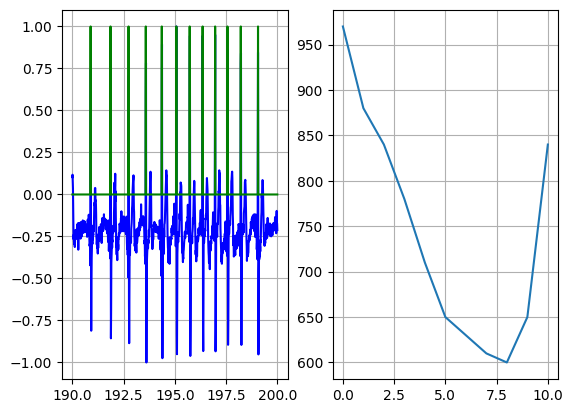

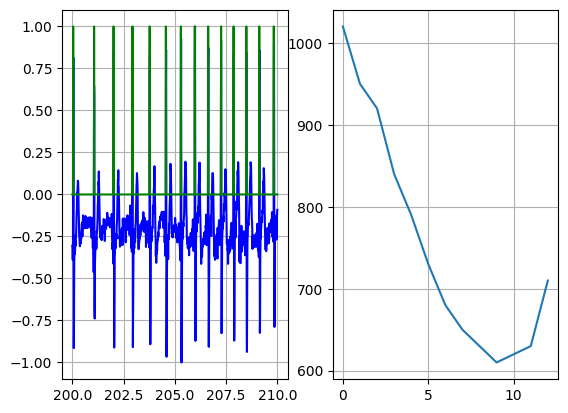

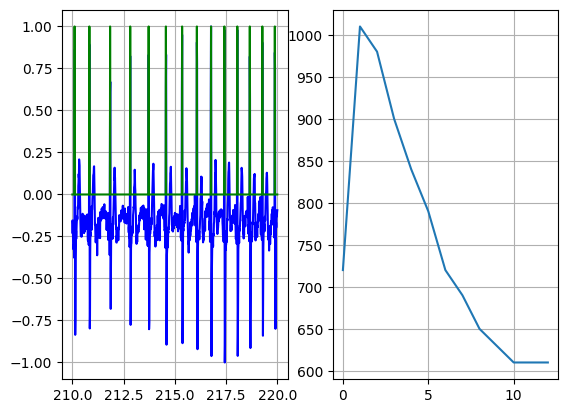

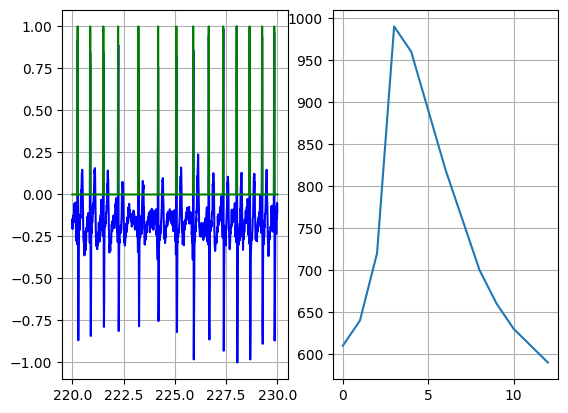

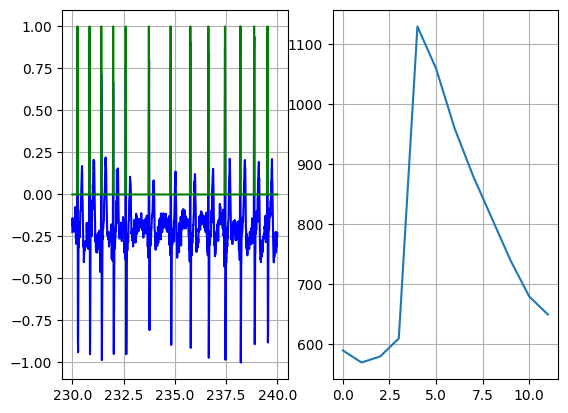

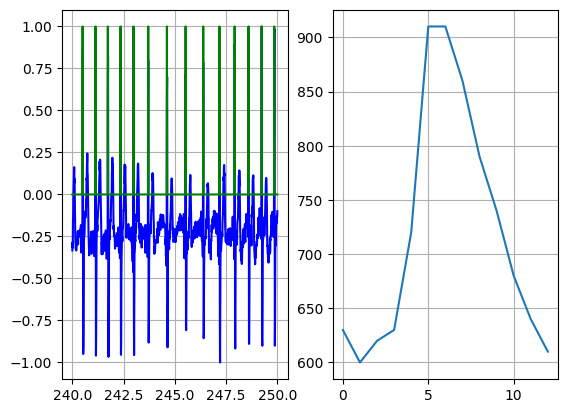

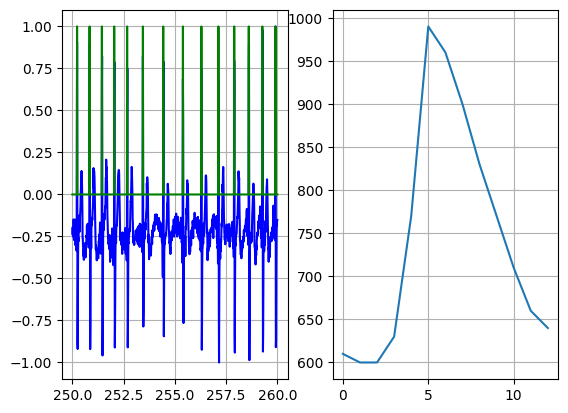

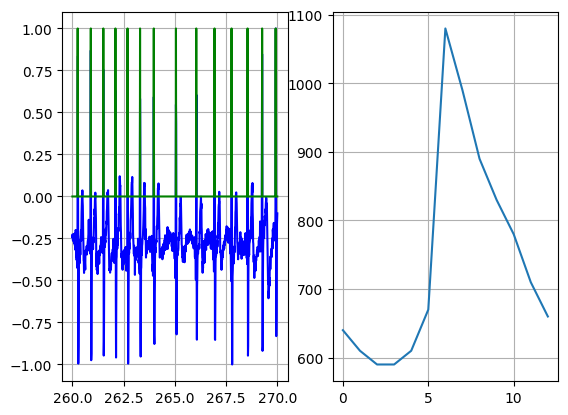

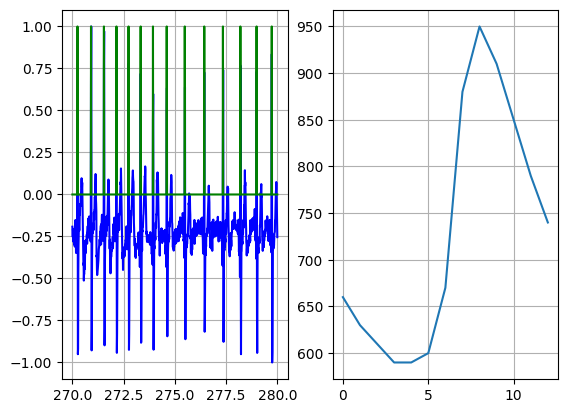

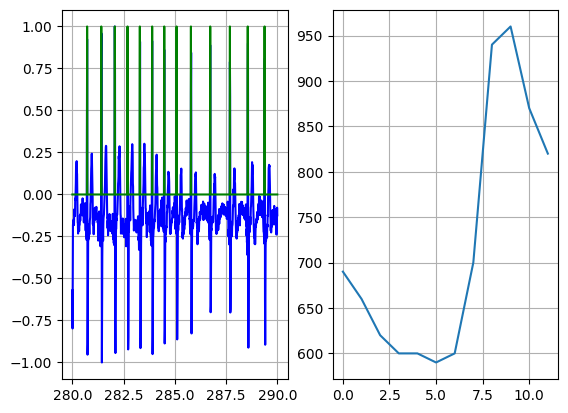

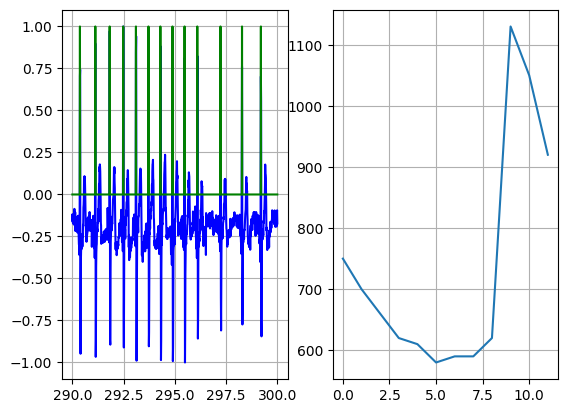

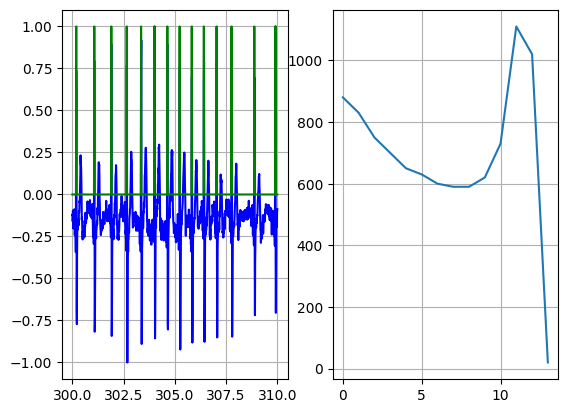

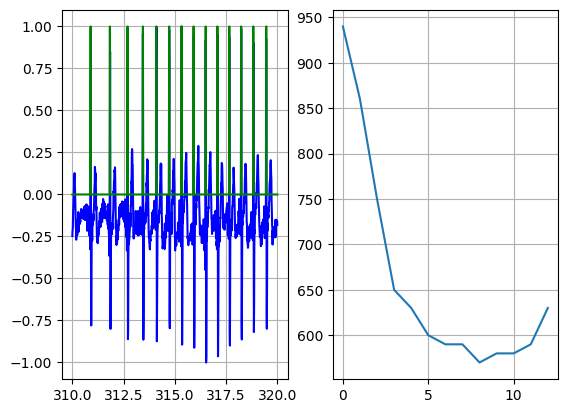

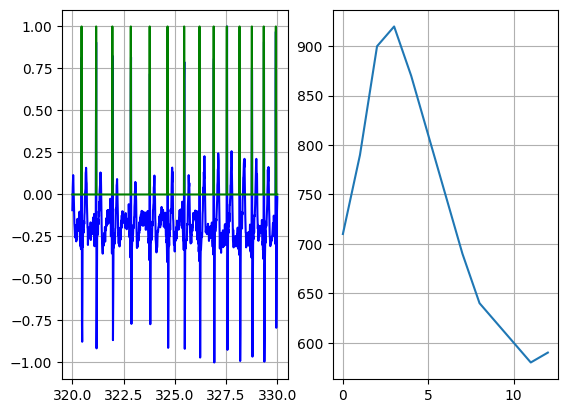

In [32]:
whole = None

times = np.linspace(start=0, stop=10, num=1000)

for i in range(x.shape[0]):
  ecg = x[i]
  gt = y[i]

  indices = np.where(predictions[i] > 0.5)[0]
  prediction = np.zeros_like(ecg.flatten())
  prediction[indices] = 1

  r_peaks = find_mean_avg_r_peak_indices(prediction)
  correct_indices = np.where(r_peaks == 1)[0]

  if whole is None:
    whole = np.array(correct_indices)
  else:
    whole = np.concatenate((whole, correct_indices + i * 1000))

  error = np.zeros_like(ecg)
  error_indices = np.where(r_peaks != gt)[0]
  error[error_indices] = 1

  fig, axs = plt.subplots(ncols=2)
  ax = axs[0]
  ax.plot(times, ecg, "b-")
  ax.plot(times, r_peaks, "g-")
  # ax.plot(times, error, "r--")
  ax.grid()

  rris = peaks_to_rri(r_peaks)

  ax = axs[1]
  ax.plot(rris)
  ax.grid()

  times += 10

In [34]:
all_r_peaks = np.zeros_like(raw_ecg)
all_r_peaks[whole] = 1
whole_ecg = x.flatten()

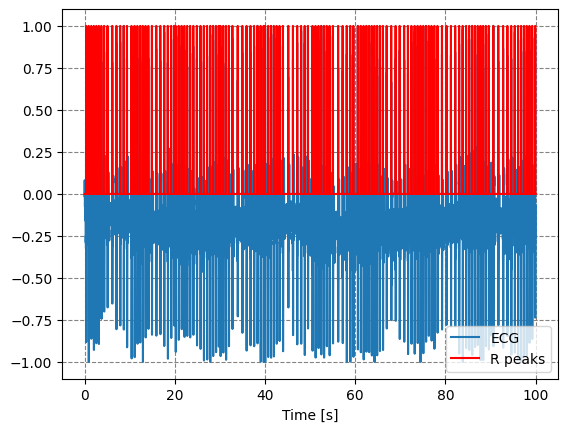

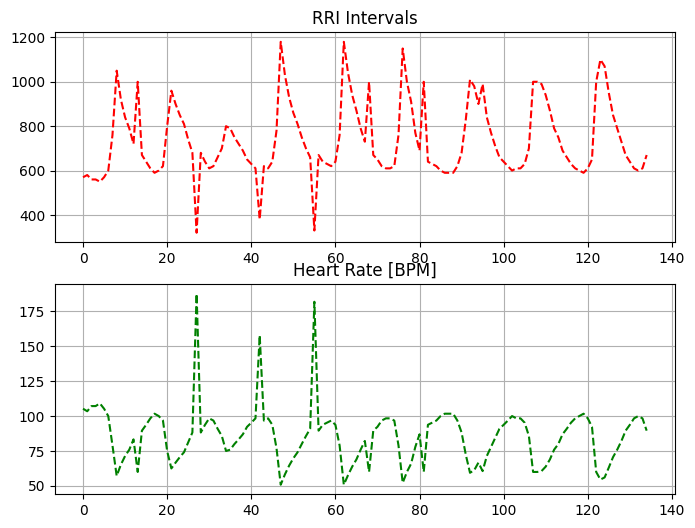

In [44]:
length = 10000

ecg = whole_ecg[:length]
r_peaks = all_r_peaks[:length]
plot_ecg(ecg, r_peaks, 100)

rri_indices = [x for x in range(len(peaks_to_rri(all_r_peaks[:length])))]
rris = peaks_to_rri(all_r_peaks[:length])

fig, axs = plt.subplots(nrows=2)
ax = axs[0]
ax.grid()
ax.plot(rri_indices, rris, "r--")
ax.set_title("RRI Intervals")

bpm = 60 / rris * 1000

ax = axs[1]
ax.grid()
ax.plot(rri_indices, bpm, "g--")
ax.set_title("Heart Rate [BPM]")

fig.set_size_inches(h=6, w=8)

## Respiratory data from the Apnea-ecg dataset

In [46]:
import os
import wfdb
from customLib.config import apnea_ecg_path

files = [x for x in os.listdir(apnea_ecg_path) if x.endswith("r.dat")]
print(files)

['a01r.dat', 'a02r.dat', 'a03r.dat', 'a04r.dat', 'b01r.dat', 'c01r.dat', 'c02r.dat', 'c03r.dat']


In [74]:
respiratory_data = wfdb.rdrecord(apnea_ecg_path + "\\a01r")
respiratory_ann = wfdb.rdann(apnea_ecg_path + "\\a01r", extension="apn")

ecg_data = wfdb.rdrecord(apnea_ecg_path + "\\a01")

In [78]:
print(respiratory_data.sig_name)
print("Respiratory sampling rate: ",  respiratory_data.fs)
print("ECG channels: ", ecg_data.n_sig)
print("ECG sampling rate: ", ecg_data.fs)
# Resp C - chest
# Resp A - abdominal
# Resp N - nasal
# SpO2 - oxygen saturation

['Resp C', 'Resp A', 'Resp N', 'SpO2']
Respiratory sampling rate:  100
ECG channels:  1
ECG sampling rate:  100


In [90]:
resp_n = respiratory_data.p_signal[:3000,2]
ecg = ecg_data.p_signal[:3000]

In [91]:
ecg_torch = torch.Tensor(np.expand_dims(ecg,0)).to(device)

In [94]:
sigmoid = torch.nn.Sigmoid()
prediction = model(ecg_torch)
prediction = sigmoid(prediction)
prediction = prediction.cpu().detach().numpy().flatten()

indices = np.where(prediction > 0.5)[0]
prediction = np.zeros_like(ecg.flatten())
prediction[indices] = 1

r_peaks = find_mean_avg_r_peak_indices(prediction)
rris = peaks_to_rri(r_peaks)

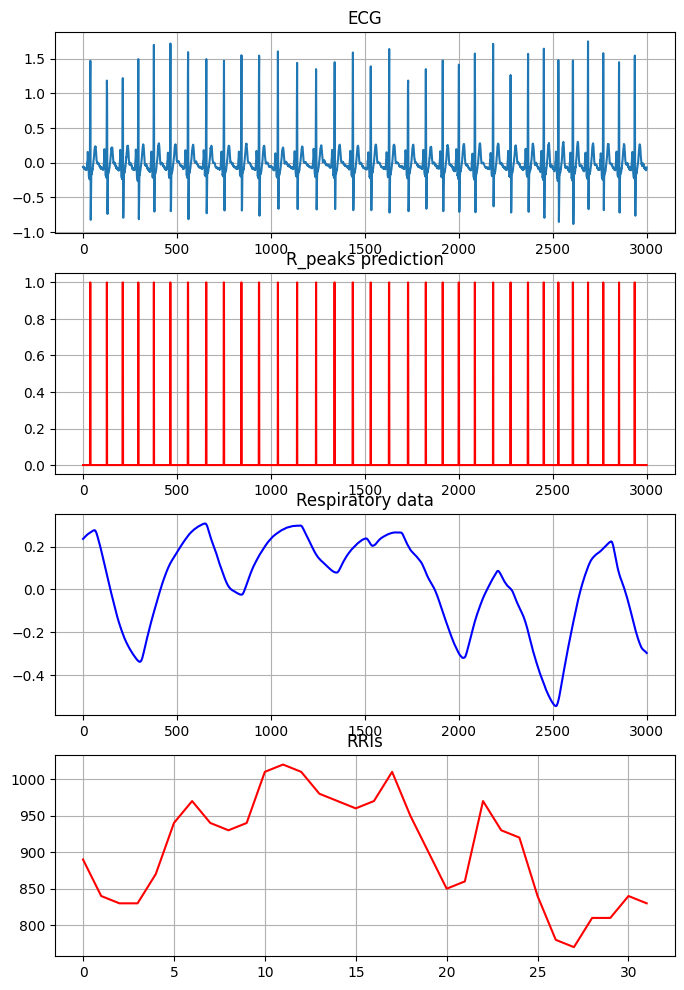

In [103]:
fig, axs = plt.subplots(nrows=4)

ax = axs[0]
ax.plot(ecg)
ax.grid()
ax.set_title("ECG")


ax = axs[1]
ax.plot(prediction, "r-")
ax.grid()
ax.set_title("R_peaks prediction")

ax = axs[2]
ax.plot(resp_n, "b-")
ax.grid()
ax.set_title("Respiratory data")

ax = axs[3]
ax.plot(rris, "r-")
ax.grid()
ax.set_title("RRIs")

fig.set_size_inches(h=12, w=8)